# Long Call Option

### I. Strategy Overview

#### Payoff

![](long_call.jpg)

#### Features:
* Long Delta: option value increases as the underlying price goes up
* Short Theta: option value decreases as time decays
* Long volatility: option value increases as the implied volatility hikes

### II. Strategy Setup

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
from Functions.Backtest import OptionBackTesting, BackTestingVisualization

####  1. Input symbol of underlying

In [2]:
Ticker = 'MSFT'

#### 2. Specify testing period and find out the expiration dates within

In [3]:
Start_Date = datetime.datetime(2017, 1, 4)
End_Date = datetime.datetime(2018,3, 1)

expiry = OptionBackTesting(Ticker, [], [], Start_Date, End_Date,  []).set_expiration_calendar()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


#### 3. Select an expiration date

In [4]:
expiration = datetime.datetime(2018, 3, 18)

#### 4. Choose option enter and exit dates

In [5]:
entry_date = datetime.datetime(2017, 1, 4)
exit_date = datetime.datetime(2018, 3, 1)

#### 5. Option Type & Strike Price Selection
* Change the strike price to see how it affects the strategy

In [6]:
option_type = 'C'
# strike_price = 55  # At the money
strike_price = 70  # Deep in the money
# strike_price = 65  # Far out of the money

### III. Visualization
#### 1. Generate options basic data

In [7]:
option_data = OptionBackTesting(Ticker, strike_price, expiration, entry_date, exit_date, option_type)
option_price, option_return, underlying_price, underlying_return, trading_days, iv, hv = option_data.generate_data()

##### 2. Speficy spot price range and generate payoff chart

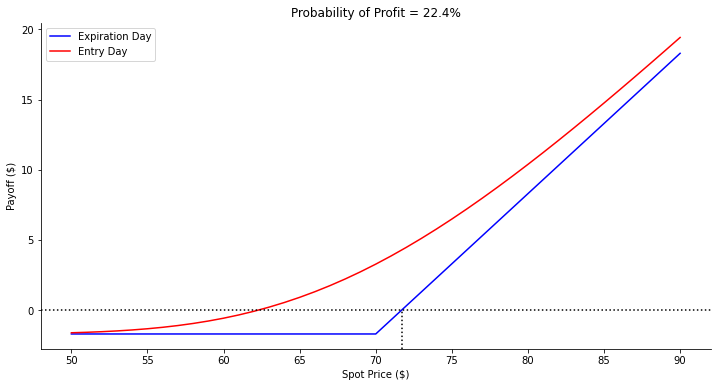

In [8]:
lower_limit = 50 # Modify to customize the lower bound of x-axis
upper_limit = 90 # Modify to customize the upper bound of x-axis

# Generate payoffs
payoff_calc = BackTestingVisualization(trading_days, option_price, underlying_price, option_return, underlying_return, iv, strike_price, expiration, entry_date, exit_date, lower_limit, upper_limit, 'C')
payoff_calc.plot_payoff()

# Probability of profit


#### 3. Price Moves

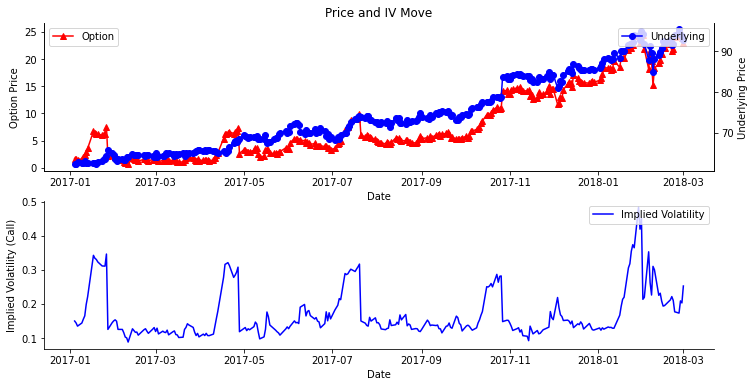

In [9]:
# viz = BackTestingVisualization(trading_days, option_price, underlying_price, option_return, underlying_return, iv,[],[],[],[],[],[])
payoff_calc.plot_price_history()

#### 4. Returns

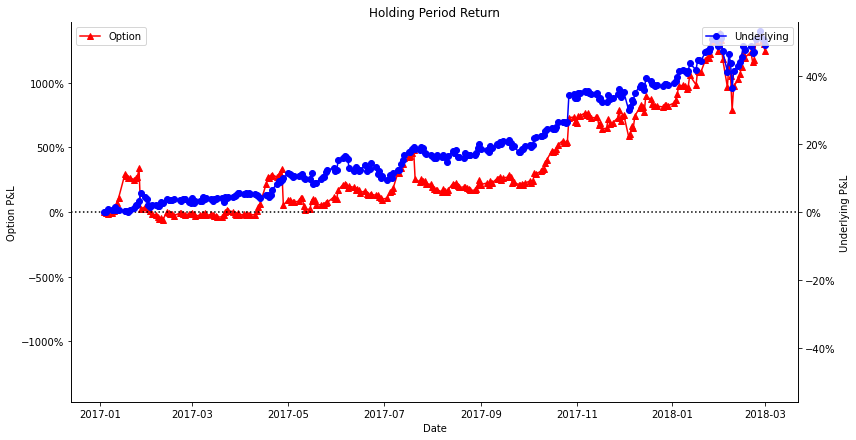

In [10]:
payoff_calc.plot_option_pnl()

### IV. Trade Journaling

In [11]:
payoff_calc.print_strategy_summary()
payoff_calc.strategy_summary

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2017-01-04,$170.45,2018-03-01,421,$2288.26,$2117.81,$5.03,1242.5%,True


### V. Recurring Strategy Setup
Get in when:
Simplified
* 1st trading day of every month
* Buy next month's expiration

Realistic:
* IV < 0
* Expiration date < 60 & Expiration date > 60
* VIX < 20

In [12]:
import pandas as pd
trading_days['Year-Month'] = trading_days['Date'].dt.to_period('M') + 1  # +1 to find the expiration date in the next month
dte_seeker = pd.merge(trading_days, expiry, on='Year-Month', how='left')
dte_seeker['DTE'] = (pd.to_datetime(dte_seeker['Trading Day']) - pd.to_datetime(dte_seeker['Date'])).dt.days
dte_seeker.dropna(inplace=True)

In [13]:
from datetime import timedelta
entry_dates = dte_seeker[dte_seeker['DTE']==43]['Date'].reset_index(drop=True)
expiration_dates = dte_seeker[dte_seeker['DTE']==43]['Trading Day'].reset_index(drop=True)
exit_dates = entry_dates + timedelta(days=22)

# exit_dates = dte_seeker[(dte_seeker['DTE']==21)]['Date']
# exit_dates[exit_dates>entry_dates[0]].reset_index(drop=True)

entry_dates

0    2017-01-04 06:00:00
1    2017-02-01 06:00:00
2    2017-03-15 05:00:00
3    2017-04-05 05:00:00
4    2017-05-03 05:00:00
5    2017-06-07 05:00:00
6    2017-07-05 05:00:00
7    2017-08-02 05:00:00
8    2017-09-06 05:00:00
9    2017-10-04 05:00:00
10   2017-11-01 05:00:00
11   2017-12-06 06:00:00
12   2018-01-03 06:00:00
Name: Date, dtype: datetime64[ns]

In [14]:
exit_dates

0    2017-01-26 06:00:00
1    2017-02-23 06:00:00
2    2017-04-06 05:00:00
3    2017-04-27 05:00:00
4    2017-05-25 05:00:00
5    2017-06-29 05:00:00
6    2017-07-27 05:00:00
7    2017-08-24 05:00:00
8    2017-09-28 05:00:00
9    2017-10-26 05:00:00
10   2017-11-23 05:00:00
11   2017-12-28 06:00:00
12   2018-01-25 06:00:00
Name: Date, dtype: datetime64[ns]

In [15]:
expiration_dates

0     2017-02-17
1     2017-03-17
2     2017-04-28
3     2017-05-19
4     2017-06-16
5     2017-07-21
6     2017-08-18
7     2017-09-15
8     2017-10-20
9     2017-11-17
10    2017-12-15
11    2018-01-19
12    2018-02-16
Name: Trading Day, dtype: object

In [16]:
import pandas as pd
expiration_dates = pd.to_datetime(expiration_dates)

In [49]:
strategy_performance = pd.DataFrame([])
i = 0
strike_price = 55
for _ in entry_dates:
    option_data = OptionBackTesting(Ticker, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], option_type)
    option_price, option_return, underlying_price, underlying_return, trading_days, iv, hv = option_data.generate_data()
    payoff_calc = BackTestingVisualization(trading_days, option_price, underlying_price, option_return, underlying_return, iv, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], lower_limit, upper_limit, 'C')
    payoff_calc.print_strategy_summary()
    strategy_performance = strategy_performance.append(payoff_calc.strategy_summary)
    i+=1
    strike_price = underlying_price['close'][-1]+5

In [50]:
win_rate = "{:.2%}".format(strategy_performance['Win'].sum()/len(strategy_performance['Win']))
# Total_Cost = "${:,.2f}".format(strategy_performance['Cost Basis'].sum())

In [39]:
win_rate_ATM

NameError: name 'win_rate_ATM' is not defined

In [31]:
strategy_performance_ATM

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2017-01-04 06:00:00,$737.40,2017-01-26 06:00:00,22,$936.86,$199.46,$9.07,27.0%,True
0,2017-02-01 06:00:00,$107.12,2017-02-23 06:00:00,22,$96.61,$-10.51,$-0.48,-9.8%,False
0,2017-03-15 05:00:00,$109.14,2017-04-06 05:00:00,22,$140.56,$31.41,$1.43,28.8%,True
0,2017-04-05 05:00:00,$98.66,2017-04-27 05:00:00,22,$356.63,$257.97,$11.73,261.5%,True
0,2017-05-03 05:00:00,$165.55,2017-05-25 05:00:00,22,$166.12,$0.56,$0.03,0.3%,True
0,2017-06-07 05:00:00,$328.90,2017-06-29 05:00:00,22,$71.15,$-257.74,$-11.72,-78.4%,False
0,2017-07-05 05:00:00,$222.24,2017-07-27 05:00:00,22,$476.38,$254.14,$11.55,114.4%,True
0,2017-08-02 05:00:00,$108.72,2017-08-24 05:00:00,22,$78.77,$-29.95,$-1.36,-27.5%,False
0,2017-09-06 05:00:00,$191.40,2017-09-28 05:00:00,22,$172.44,$-18.96,$-0.86,-9.9%,False
0,2017-10-04 05:00:00,$188.17,2017-10-26 05:00:00,22,$543.28,$355.11,$16.14,188.7%,True


In [40]:
win_rate

'84.62%'

In [48]:
pd.to_datetime(strategy_performance['Exit Date']).dt.date

0    2017-01-26
0    2017-02-23
0    2017-04-06
0    2017-04-27
0    2017-05-25
0    2017-06-29
0    2017-07-27
0    2017-08-24
0    2017-09-28
0    2017-10-26
0    2017-11-23
0    2017-12-28
0    2018-01-25
Name: Exit Date, dtype: object

In [51]:
win_rate

'38.46%'

In [52]:
strategy_performance_OTM

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2017-01-04 06:00:00,$737.40,2017-01-26 06:00:00,22,$936.86,$199.46,$9.07,27.0%,True
0,2017-02-01 06:00:00,$8.42,2017-02-23 06:00:00,22,$0.64,$-7.78,$-0.35,-92.4%,False
0,2017-03-15 05:00:00,$3.07,2017-04-06 05:00:00,22,$0.96,$-2.11,$-0.10,-68.8%,False
0,2017-04-05 05:00:00,$3.00,2017-04-27 05:00:00,22,$110.46,$107.47,$4.88,3583.9%,True
0,2017-05-03 05:00:00,$11.81,2017-05-25 05:00:00,22,$2.93,$-8.88,$-0.40,-75.2%,False
0,2017-06-07 05:00:00,$65.15,2017-06-29 05:00:00,22,$2.64,$-62.51,$-2.84,-95.9%,False
0,2017-07-05 05:00:00,$49.46,2017-07-27 05:00:00,22,$101.57,$52.11,$2.37,105.3%,True
0,2017-08-02 05:00:00,$10.16,2017-08-24 05:00:00,22,$1.55,$-8.60,$-0.39,-84.7%,False
0,2017-09-06 05:00:00,$26.70,2017-09-28 05:00:00,22,$8.22,$-18.48,$-0.84,-69.2%,False
0,2017-10-04 05:00:00,$22.51,2017-10-26 05:00:00,22,$214.62,$192.11,$8.73,853.3%,True
